In [2]:
#Étapes pour appliquer la méthode de Markowitz :

##La théorie de Markowitz (ou théorie moderne du portefeuille) 
# repose sur l'optimisation des portefeuilles 
# en fonction du couple rendement attendu et risque (volatilité). 
# L'objectif est de construire un portefeuille 
# qui maximise le rendement attendu pour un niveau de risque donné 
# ou qui minimise le risque pour un rendement attendu donné.



#####Théorie de Markowitz :
# Objectif : Construire un portefeuille qui équilibre rendement et risque en fonction de la frontière efficiente.
#   La frontière efficiente est l'ensemble des portefeuilles optimaux offrant le rendement attendu maximal pour un niveau de risque donné, 
# ou le risque minimal pour un rendement attendu donné.
#Hypothèses :
#   Les investisseurs sont rationnels et préfèrent des portefeuilles avec un meilleur compromis rendement-risque.
#  Le risque est mesuré par la volatilité (écart-type).
# Les rendements suivent une distribution normale.
#Approche :
#   Minimiser la volatilité (risque) pour un rendement attendu donné.
#  Ou maximiser le rendement attendu pour une volatilité donnée. 

In [3]:
#####################################1. Collecte et Préparation des Données

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: Load tickers from the specified CSV
tickers_df = pd.read_csv('C:/Users/lydie/OneDrive/Bureau/M2 Modélisation Financière/Gestion de portefeuilles/Project/portfolio.csv')
tickers = tickers_df['Symbol'].dropna().tolist()

# Step 2: Download price of stocks
data = yf.download(tickers, start='2015-01-01', end='2023-01-01')['Adj Close']

# Step 3: Time index for stocks
data.index = data.index.strftime('%Y-%m-%d')

# Step 4: Remove stocks with more than 10% missing data
threshold = 0.1  # 10% missing data threshold
max_missing_allowed = int(threshold * len(data))
data_filtered = data.loc[:, data.isnull().sum() <= max_missing_allowed]
data_final = data_filtered.dropna()

# Step 5: Interpolate the remaining data
data_interpolated = data_filtered.interpolate(method='linear', axis=0)

# Step 6: Verify if there is any remaining missing data
remaining_missing = data_interpolated.isnull().sum().sum()
if remaining_missing == 0:
    print("All data complete after filtering and interpolation!")
else:
    print(f"{remaining_missing} missing values remain after processing.")

# Final Step: Print the processed data
print(data_interpolated)

# Calcul des statistiques
returns = data_interpolated.pct_change().dropna()
mean_returns = returns.mean() * 252  # Rendements annuels moyens
cov_matrix = returns.cov() * 252  # Matrice de covariance annualisée
risk_free_rate = 0.04  # Taux sans risque (à ajuster)######################################################################################

[*********************100%***********************]  206 of 206 completed


All data complete after filtering and interpolation!
Ticker               A        AAPL        ABBV         ACN        ADBE  \
Date                                                                     
2015-01-02   37.422047   24.347174   43.563179   75.312737   72.339996   
2015-01-05   36.720840   23.661266   42.743351   74.041138   71.980003   
2015-01-06   36.148815   23.663500   42.531784   73.507072   70.529999   
2015-01-07   36.628578   23.995312   44.250771   75.049927   71.110001   
2015-01-08   37.726521   24.917267   44.713581   76.194382   72.919998   
...                ...         ...         ...         ...         ...   
2022-12-23  147.185059  130.487808  151.238388  257.784546  338.450012   
2022-12-27  147.500687  128.676849  151.136383  257.028900  335.089996   
2022-12-28  146.060699  124.728371  150.431656  254.907227  328.329987   
2022-12-29  149.019562  128.261230  150.737656  260.003082  337.579987   
2022-12-30  147.819427  128.577881  149.856766  258.511139 

In [4]:
# Séparer les périodes
train_data = returns['2015-01-01':'2018-12-31']
test_data = returns['2019-01-01':'2023-12-31']

# Calcul des statistiques pour la période d'entraînement
mean_returns_train = train_data.mean() * 252  # Rendements moyens annuels
cov_matrix_train = train_data.cov() * 252  # Matrice de covariance annualisée

# Fonction pour calculer la volatilité du portefeuille
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Initialisation
num_assets = len(mean_returns_train)
init_weights = np.ones(num_assets) / num_assets  # Poids initiaux égaux
bounds = tuple((0, 1) for _ in range(num_assets))  # Les poids sont entre 0 et 1


In [5]:
# Optimisation selon Markowitz
# a) Minimiser la volatilité pour un rendement donné
target_return = mean_returns_train.mean() + 0.01  # Rendement cible légèrement au-dessus de la moyenne

print("Rendement cible:", target_return)

constraints_min_vol = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Somme des poids = 1
    {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns_train) - target_return}  # Rendement cible atteint
)

result_min_vol = minimize(portfolio_volatility, init_weights, args=(cov_matrix_train,),
                          method='SLSQP', bounds=bounds, constraints=constraints_min_vol)

optimal_weights_min_vol = result_min_vol.x
optimal_volatility = portfolio_volatility(optimal_weights_min_vol, cov_matrix_train)

print("Poids optimaux (risque min pour rendement donné) :", optimal_weights_min_vol)
print("Volatilité minimale (entraînement) :", optimal_volatility)

Rendement cible: 0.16469673376105629
Poids optimaux (risque min pour rendement donné) : [1.97837577e-17 3.88419683e-17 9.37610951e-17 2.30190299e-19
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.04687628e-16 1.63762858e-17 2.27838765e-04
 8.63540787e-17 3.56726223e-17 0.00000000e+00 2.41725978e-17
 0.00000000e+00 5.64709757e-02 4.72235121e-17 4.95038794e-02
 4.41894543e-17 0.00000000e+00 1.11449952e-16 1.11044623e-03
 2.79780827e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.88848626e-03 3.69298454e-18 3.68677323e-03
 7.54350641e-03 0.00000000e+00 0.00000000e+00 2.90274960e-17
 2.94942025e-17 4.57416082e-18 0.00000000e+00 0.00000000e+00
 1.41147382e-17 0.00000000e+00 4.17524048e-17 6.99029833e-18
 0.00000000e+00 0.00000000e+00 2.04825600e-17 3.66656010e-02
 7.58045808e-02 0.00000000e+00 1.35935245e-02 5.56137978e-17
 9.10186557e-18 4.64782789e-17 1.57339412e-02 9.94175372e-19
 0.00000000e+00 2.29490314e-17 3.99481908e-18 2.13035189e-

In [ ]:
# b) Maximiser le rendement pour un risque donné
target_risk = train_data.std(axis=0).mean() * np.sqrt(252)  # Volatilité moyenne annualisée (Risque cible).

print("Risque cible:", target_risk)

constraints_max_ret = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Somme des poids = 1
    {'type': 'ineq', 'fun': lambda x: target_risk - portfolio_volatility(x, cov_matrix_train)}  # Risque cible
)

result_max_ret = minimize(lambda x: -np.dot(x, mean_returns_train), init_weights,
                          method='SLSQP', bounds=bounds, constraints=constraints_max_ret)

optimal_weights_max_ret = result_max_ret.x
optimal_return = np.dot(optimal_weights_max_ret, mean_returns_train)

print("Poids optimaux (rendement max pour risque donné) :", optimal_weights_max_ret)
print("Rendement attendu (entraînement) :", optimal_return)

Risque cible: 0.28903774817353783
Poids optimaux (rendement max pour risque donné) : [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.21767042e-17 1.00228797e-15
 0.00000000e+00 2.10419017e-16 0.00000000e+00 2.07934468e-01
 5.76963687e-16 6.26025065e-17 3.52307421e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.80253792e-16 0.00000000e+00
 1.07253337e-15 0.00000000e+00 0.00000000e+00 5.04199683e-16
 3.92703605e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.67136909e-17 3.80520830e-16 1.37342996e-16 0.00000000e+00
 0.00000000e+00 2.72392172e-16 0.00000000e+00 4.84356105e-16
 2.42439811e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.04163896e-16 0.00000000e+00
 0.00000000e+00 5.12994384e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.10953416e-16 0.00000000e+00 3.05985604e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00


In [7]:
# Évaluation sur la période de test
portfolio_test_returns_min_vol = test_data.dot(optimal_weights_min_vol)
portfolio_test_returns_max_ret = test_data.dot(optimal_weights_max_ret)

# Statistiques sur la période de test
mean_portfolio_return_min_vol = portfolio_test_returns_min_vol.mean() * 252
vol_portfolio_min_vol = portfolio_test_returns_min_vol.std() * np.sqrt(252)

mean_portfolio_return_max_ret = portfolio_test_returns_max_ret.mean() * 252
vol_portfolio_max_ret = portfolio_test_returns_max_ret.std() * np.sqrt(252)

print("\nÉvaluation sur la période de test (risque min):")
print("Rendement moyen (test) :", mean_portfolio_return_min_vol)
print("Volatilité (test) :", vol_portfolio_min_vol)

print("\nÉvaluation sur la période de test (rendement max):")
print("Rendement moyen (test) :", mean_portfolio_return_max_ret)
print("Volatilité (test) :", vol_portfolio_max_ret)


Évaluation sur la période de test (risque min):
Rendement moyen (test) : 0.15164331967661426
Volatilité (test) : 0.18055429365335648

Évaluation sur la période de test (rendement max):
Rendement moyen (test) : 0.4472230508662672
Volatilité (test) : 0.39894780600034147


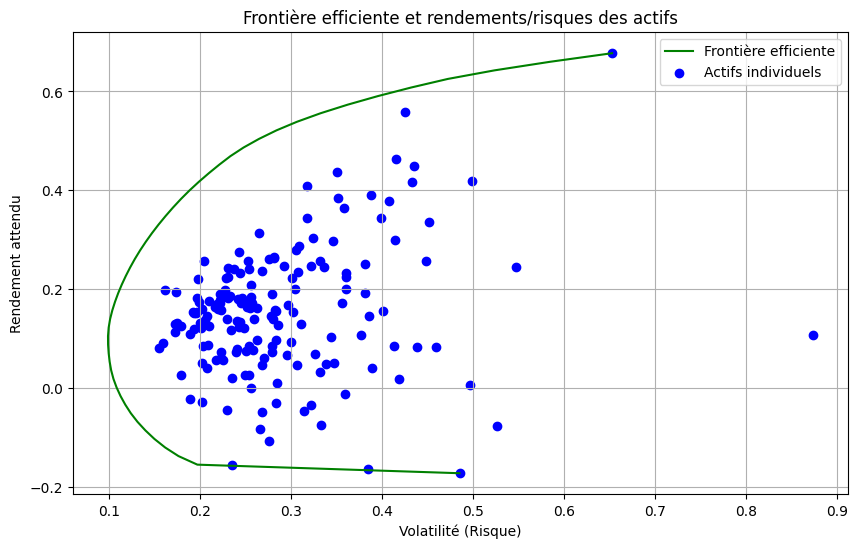

In [ ]:
########################################### Tracer la frontière efficiente
#La frontière efficiente est l'ensemble des portefeuilles optimaux en fonction du compromis rendement-risque.

# Fonction pour optimiser le portefeuille pour une cible de rendement donnée
def efficient_frontier(mean_returns, cov_matrix, num_points=50):
    target_returns = np.linspace(mean_returns.min(), mean_returns.max(), num_points)  # Plage de rendements cibles
    frontier_volatilities = []  # Stocker les volatilités pour chaque rendement cible

    for target_return in target_returns:
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Somme des poids = 1
            {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_return}  # Rendement cible atteint
        )
        result = minimize(portfolio_volatility, init_weights, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)
        frontier_volatilities.append(result.fun)

    return target_returns, frontier_volatilities

# Calculer la frontière efficiente pour la période d'entraînement
target_returns, frontier_volatilities = efficient_frontier(mean_returns_train, cov_matrix_train)

# Tracer la frontière efficiente
volatility_train = np.sqrt(np.diag(cov_matrix_train))
plt.figure(figsize=(10, 6))
plt.plot(frontier_volatilities, target_returns, label='Frontière efficiente', color='green')
plt.scatter(volatility_train, mean_returns_train, c='blue', marker='o', label='Actifs individuels')
plt.xlabel('Volatilité (Risque)')
plt.ylabel('Rendement attendu')
plt.title('Frontière efficiente et rendements/risques des actifs')
plt.legend()
plt.grid()
plt.show()

In [12]:
 #Analyse du ratio de Sharpe et autres métriques
#a) Ratio de Sharpe
#Le ratio de Sharpe mesure le rendement excédentaire (par rapport au taux sans risque) par unité de risque (volatilité).
#Calculez le ratio de Sharpe pour les portefeuilles optimaux obtenus

# Ratio de Sharpe pour le portefeuille (risque minimum) sur la période de test
sharpe_ratio_min_vol = (mean_portfolio_return_min_vol - risk_free_rate) / vol_portfolio_min_vol

# Ratio de Sharpe pour le portefeuille (rendement maximum) sur la période de test
sharpe_ratio_max_ret = (mean_portfolio_return_max_ret - risk_free_rate) / vol_portfolio_max_ret

print("\nRatio de Sharpe (test) pour le portefeuille à risque minimum :", sharpe_ratio_min_vol)
print("Ratio de Sharpe (test) pour le portefeuille à rendement maximum :", sharpe_ratio_max_ret)



Ratio de Sharpe (test) pour le portefeuille à risque minimum : 0.6183365536072857
Ratio de Sharpe (test) pour le portefeuille à rendement maximum : 1.020742675461458


In [13]:
#b) Tracking Error

#Le tracking error mesure la divergence entre les rendements d'un portefeuille et son benchmark.
# Supposons que le benchmark soit une moyenne des actifs ou un indice (par exemple, S&P 500)
benchmark_returns = test_data.mean(axis=1)  # Moyenne des rendements des actifs comme benchmark

# Calcul du tracking error
tracking_error_min_vol = np.sqrt(((portfolio_test_returns_min_vol - benchmark_returns) ** 2).mean()) * np.sqrt(252)
tracking_error_max_ret = np.sqrt(((portfolio_test_returns_max_ret - benchmark_returns) ** 2).mean()) * np.sqrt(252)

print("\nTracking Error (test) pour le portefeuille à risque minimum :", tracking_error_min_vol)
print("Tracking Error (test) pour le portefeuille à rendement maximum :", tracking_error_max_ret)



Tracking Error (test) pour le portefeuille à risque minimum : 0.11672863822631525
Tracking Error (test) pour le portefeuille à rendement maximum : 0.22638456165708978


In [14]:
#c) Drawdown maximal

#Le drawdown maximal mesure la plus grande perte cumulée subie par le portefeuille.
# Fonction pour calculer le maximum drawdown
def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()  # Valeur cumulée du portefeuille
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    return drawdown.min()

# Calcul du maximum drawdown
max_drawdown_min_vol = max_drawdown(portfolio_test_returns_min_vol)
max_drawdown_max_ret = max_drawdown(portfolio_test_returns_max_ret)

print("\nMaximum Drawdown (test) pour le portefeuille à risque minimum :", max_drawdown_min_vol)
print("Maximum Drawdown (test) pour le portefeuille à rendement maximum :", max_drawdown_max_ret)




Maximum Drawdown (test) pour le portefeuille à risque minimum : -0.3127465793682943
Maximum Drawdown (test) pour le portefeuille à rendement maximum : -0.42966234720325147



### Scénario de Stress (Crash de Marché) ###
Rendement annuel moyen après stress (risque min) : -50.24835668032347
Rendement annuel moyen après stress (rendement max) : -49.95277694913666

### Scénario de Volatilité Accrue ###
Rendement annuel moyen après volatilité accrue (risque min) : 0.16909054859935305
Rendement annuel moyen après volatilité accrue (rendement max) : 0.6187232132991594


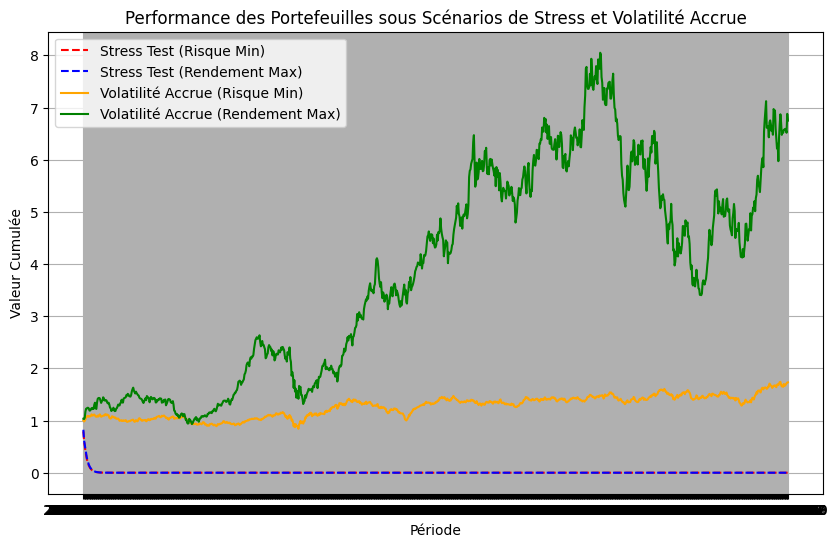

In [15]:
#2. Simulation de scénarios de marché

# a) Scénario de stress (crash de marché)
# Simuler une baisse brutale des actifs pour évaluer la robustesse du portefeuille
stress_returns = test_data.copy() - 0.20  # Réduction de 20% des rendements

# Calcul de l'impact sur les portefeuilles
stress_portfolio_min_vol = stress_returns.dot(optimal_weights_min_vol)
stress_portfolio_max_ret = stress_returns.dot(optimal_weights_max_ret)

# Calcul des statistiques
stress_mean_return_min_vol = stress_portfolio_min_vol.mean() * 252
stress_mean_return_max_ret = stress_portfolio_max_ret.mean() * 252

# Affichage des résultats
print("\n### Scénario de Stress (Crash de Marché) ###")
print("Rendement annuel moyen après stress (risque min) :", stress_mean_return_min_vol)
print("Rendement annuel moyen après stress (rendement max) :", stress_mean_return_max_ret)

# b) Scénario de volatilité accrue
# Ajouter une volatilité artificielle pour tester la performance dans des conditions de marché instables
np.random.seed(42)  # Assurez la reproductibilité
volatile_returns = test_data + np.random.normal(0, 0.05, test_data.shape)  # Ajouter 5% de volatilité artificielle

# Calcul de l'impact sur les portefeuilles
volatile_portfolio_min_vol = volatile_returns.dot(optimal_weights_min_vol)
volatile_portfolio_max_ret = volatile_returns.dot(optimal_weights_max_ret)

# Calcul des statistiques
volatile_mean_return_min_vol = volatile_portfolio_min_vol.mean() * 252
volatile_mean_return_max_ret = volatile_portfolio_max_ret.mean() * 252

print("\n### Scénario de Volatilité Accrue ###")
print("Rendement annuel moyen après volatilité accrue (risque min) :", volatile_mean_return_min_vol)
print("Rendement annuel moyen après volatilité accrue (rendement max) :", volatile_mean_return_max_ret)

# Optionnel : Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot((1 + stress_portfolio_min_vol).cumprod(), label="Stress Test (Risque Min)", linestyle='--', color='red')
plt.plot((1 + stress_portfolio_max_ret).cumprod(), label="Stress Test (Rendement Max)", linestyle='--', color='blue')
plt.plot((1 + volatile_portfolio_min_vol).cumprod(), label="Volatilité Accrue (Risque Min)", linestyle='-', color='orange')
plt.plot((1 + volatile_portfolio_max_ret).cumprod(), label="Volatilité Accrue (Rendement Max)", linestyle='-', color='green')
plt.title("Performance des Portefeuilles sous Scénarios de Stress et Volatilité Accrue")
plt.xlabel("Période")
plt.ylabel("Valeur Cumulée")
plt.legend()
plt.grid()
plt.show()



In [ ]:
#1. Scénario de Stress (Crash de Marché)

 #   Risque Min Portfolio : Rendement annuel moyen après stress : -50.25%.
  #  Max Return Portfolio : Rendement annuel moyen après stress : -49.95%.

#Interprétation :
  # Les deux portefeuilles subissent des pertes massives, proches de -50%, sous un scénario de stress. Cela montre leur vulnérabilité face à des chutes brutales du marché, bien que les pertes soient légèrement moindres pour le portefeuille à rendement maximal.

#2. Scénario de Volatilité Accrue

 #   Risque Min Portfolio : Rendement annuel moyen : 16.91%.
  #  Max Return Portfolio : Rendement annuel moyen : 61.87%.

#Interprétation :

 #   Dans un environnement de volatilité accrue, le portefeuille à rendement maximal performe significativement mieux. Cela reflète une capacité à tirer parti des mouvements du marché, au détriment d'une plus grande exposition au risque.

#Comparaison Globale :

  #  Portefeuille à Risque Minimal : Plus stable dans des scénarios où la volatilité augmente progressivement, mais moins performant.
   # Portefeuille à Rendement Maximal : Malgré des pertes similaires dans des scénarios de stress extrême, il surperforme dans des conditions de volatilité accrue grâce à sa stratégie plus agressive.

In [20]:
# Résumé des performances
results = {
    "Metric": ["Mean Return (Test)", "Volatility (Test)", "Sharpe Ratio (Test)", "Tracking Error"],
    "Risk Min Portfolio": [
        mean_portfolio_return_min_vol, 
        vol_portfolio_min_vol, 
        sharpe_ratio_min_vol, 
        tracking_error_min_vol
    ],
    "Max Return Portfolio": [
        mean_portfolio_return_max_ret, 
        vol_portfolio_max_ret, 
        sharpe_ratio_max_ret, 
        tracking_error_max_ret
    ]
}

# Affichage sous forme de tableau
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

                Metric  Risk Min Portfolio  Max Return Portfolio
0   Mean Return (Test)            0.151643              0.447223
1    Volatility (Test)            0.180554              0.398948
2  Sharpe Ratio (Test)            0.618337              1.020743
3       Tracking Error            0.116729              0.226385


In [ ]:
#1. Mean Return (Test)

  #  Risque Min Portfolio : Rendement annuel moyen de 0.1516 (15.16%). Ce portefeuille favorise la stabilité mais génère des rendements modestes.
   # Max Return Portfolio : Rendement annuel moyen de 0.4472 (44.72%). Ce portefeuille est beaucoup plus agressif en termes de rendement.

#Conclusion : Le portefeuille à rendement maximal est plus performant en termes de rendement attendu, mais au prix d'une volatilité accrue.

#2. Volatility (Test)

   # Risque Min Portfolio : Volatilité annuelle de 0.1806 (18.06%). Ce portefeuille est conçu pour minimiser le risque.
#    Max Return Portfolio : Volatilité annuelle de 0.3989 (39.89%). La volatilité élevée reflète le risque accru pris pour maximiser le rendement.

#Conclusion : Le portefeuille à risque minimal est plus adapté pour les investisseurs averses au risque, tandis que le portefeuille à rendement maximal est plus volatile.

#3. Sharpe Ratio (Test)

#    Risque Min Portfolio : Ratio de Sharpe de 0.6183. Bien que modéré, ce ratio indique que le rendement généré par unité de risque est acceptable.
 #   Max Return Portfolio : Ratio de Sharpe de 1.0207. Ce portefeuille offre une meilleure efficacité (rendement/risque).

#Conclusion : Le portefeuille à rendement maximal domine sur le plan du ratio de Sharpe, montrant une meilleure gestion du compromis rendement-risque.

#4. Tracking Error

 #   Risque Min Portfolio : 0.1167 (11.67%). Ce faible écart suggère que ce portefeuille est relativement stable et proche du benchmark.
 #   Max Return Portfolio : 0.2264 (22.64%). L'écart plus élevé montre que ce portefeuille s'éloigne davantage du benchmark en termes de composition.

#Conclusion : Le portefeuille à risque minimal est plus proche du benchmark, tandis que le portefeuille à rendement maximal prend des positions plus agressives et différenciées.

#Analyse globale :

   # Le choix entre ces portefeuilles dépend des objectifs d'investissement :
  #      Si stabilité et faible risque sont prioritaires → privilégiez le portefeuille à risque minimal.
    #    Si rendement élevé est prioritaire, avec une tolérance pour la volatilité → privilégiez le portefeuille à rendement maximal.

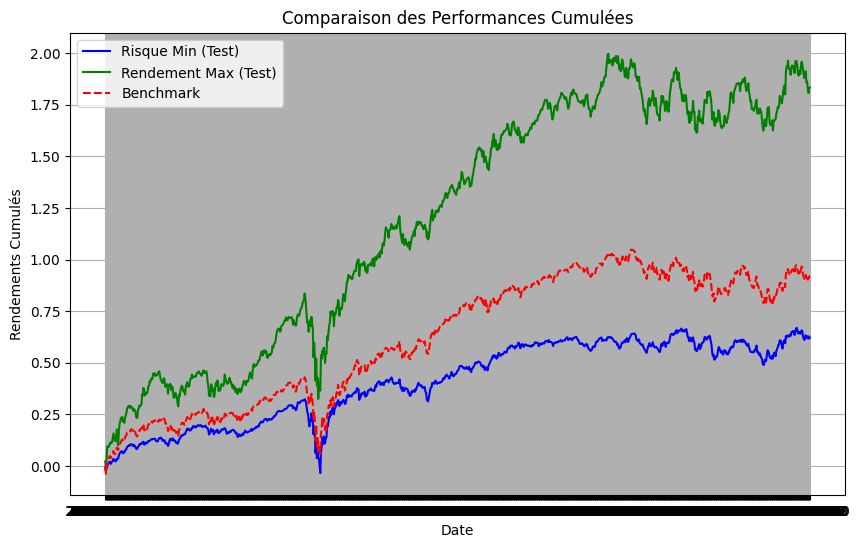

In [18]:
# Rendements cumulés
cum_returns_min = portfolio_test_returns_min_vol.cumsum()
cum_returns_max = portfolio_test_returns_max_ret.cumsum()

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(cum_returns_min, label="Risque Min (Test)", color="blue")
plt.plot(cum_returns_max, label="Rendement Max (Test)", color="green")
plt.plot(benchmark_returns.cumsum(), label="Benchmark", linestyle="--", color="red")
plt.title("Comparaison des Performances Cumulées")
plt.xlabel("Date")
plt.ylabel("Rendements Cumulés")
plt.legend()
plt.grid()
plt.show()
